In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import glob
import librosa as lbr
from librosa.feature import mfcc

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN, Bidirectional, BatchNormalization, Dropout
from tensorflow.keras.optimizers import  Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.metrics import TopKCategoricalAccuracy, Precision, Recall

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, top_k_accuracy_score, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_loso = pd.read_csv('/home/mishra.g/spring2022/hci/project/all_data_with_subject_info.csv', index_col=0)

In [33]:
data_loso.shape

(466946, 36)

In [34]:
data_loso.describe()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
count,4.669460e+05,4.669460e+05,4.669460e+05,4.669460e+05,4.669460e+05,4.669460e+05,466946.000000,4.669460e+05,4.669460e+05,466946.000000,...,4.669460e+05,466946.0,466946.0,466946.000000,466946.000000,466946.000000,466946.000000,4.669460e+05,4.669460e+05,466946.000000
mean,-1.371848e-09,7.117808e-05,4.545437e-05,-3.316419e-04,2.723802e-04,6.040221e-04,-0.000002,2.884729e-05,5.981615e-05,1320.450778,...,4.547464e-05,0.0,1280.0,175.739829,198.488737,5.794237,46.897780,2.114371e-05,1.002190e-03,4.048226
std,1.224639e-06,5.650618e-05,3.918939e-05,2.593679e-04,2.449803e-04,4.823683e-04,0.000007,2.963382e-05,5.987735e-05,149.110091,...,6.753181e-05,0.0,0.0,23.630278,40.516187,1.593385,30.710310,1.649158e-04,7.076597e-04,1.798132
min,-7.368356e-05,1.529599e-09,6.499823e-10,-1.270889e-02,5.637792e-09,1.978861e-08,-0.000305,5.834565e-11,1.037234e-10,743.000000,...,1.581693e-09,0.0,1280.0,61.000000,2.000000,2.110519,2.799972,5.989561e-15,1.924965e-08,0.000000
25%,-3.578766e-07,4.238767e-05,2.662588e-05,-4.488794e-04,1.595140e-04,3.646481e-04,-0.000006,1.556163e-05,3.280617e-05,1231.000000,...,1.284978e-05,0.0,1280.0,160.000000,170.000000,4.634118,26.449085,4.599589e-06,6.053215e-04,2.000000
50%,-1.067626e-09,6.017804e-05,3.924857e-05,-2.800288e-04,2.439199e-04,5.160467e-04,-0.000001,2.502895e-05,5.188825e-05,1329.000000,...,2.660807e-05,0.0,1280.0,172.000000,193.000000,5.517057,39.268650,9.270776e-06,8.585776e-04,4.000000
75%,3.622177e-07,9.091772e-05,5.774767e-05,-1.876482e-04,3.300490e-04,7.793854e-04,0.000001,3.584508e-05,7.473918e-05,1414.000000,...,5.098973e-05,0.0,1280.0,187.000000,220.000000,6.607893,57.033825,2.116104e-05,1.285188e-03,6.000000
max,9.320670e-05,2.874333e-03,1.970092e-03,-1.415082e-08,1.469321e-02,2.580238e-02,0.000361,1.706161e-03,3.411037e-03,1849.000000,...,4.632899e-03,0.0,1280.0,369.000000,493.000000,22.645591,627.079898,2.115019e-02,3.472487e-02,7.000000


In [4]:
subjects = data_loso.index.unique().values
labels = ['No Pathology','Bruxism','Insomnia','Narcolepsy','NFLE','PLM','RBD','SDB']
metrics_header = ['Subject Name', 'Train Samples','Val Samples','Tr:Accuracy', 'Tr:Precision','Tr:Recall','Tr:F1', 'Val:Accuracy', 'Val:Precision','Val:Recall','Val:F1']

In [137]:
metrics = []
for one_subject in subjects:
    #if(one_subject == 'ins3'):
    #    continue;
    print(f"Validating on subject:{one_subject}");
    data_train = data_loso[data_loso.index != one_subject]
    data_val = data_loso[data_loso.index==one_subject]
    print(f"Training on {len(data_train)} data points and validating on {len(data_val)}({(len(data_val)*100/len(data_loso))}%)data points")
    
    x_train = data_train.iloc[:,:-1]
    y_train = data_train.iloc[:,-1]
    x_val = data_val.iloc[:,:-1]
    y_val = data_val.iloc[:,-1]
    print('Training Started')
    rf = RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample', n_jobs=-1).fit(x_train, y_train);
    print('Training Done!')
    print('Training Metrics')
    y_pred_tr = rf.predict(x_train)
    y_pred_proba = rf.predict_proba(x_train)
    print(classification_report(y_pred_tr,y_train.values, target_names= labels))

    
    print('\nValidation Metrics')
    y_pred_val = rf.predict(x_val)
    print(classification_report(y_pred_val,y_val.values))#, target_names= ['Insomnia']))
    
    
    metrics.append([one_subject,len(x_train) ,len(x_val), accuracy_score(y_pred_tr, y_train.values), precision_score(y_pred_tr, y_train.values, average='macro'), recall_score(y_pred_tr, y_train.values,average='macro'), f1_score(y_pred_tr, y_train.values,average='macro'), accuracy_score(y_pred_val, y_val.values), precision_score(y_pred_val, y_val.values,average='macro'), recall_score(y_pred_val, y_val.values, average='macro'), f1_score(y_pred_val, y_val.values,average='macro')])
    print(metrics)
    #break;
    print('Training and validation done! Moving on to next...')
    print('\n')
    
metrics = pd.DataFrame(metrics)
metrics.to_csv('/home/mishra.g/spring2022/hci/project/loso_metrics.csv', header=metrics_header, index=False)

Validating on subject:ins3
Training on 463526 data points and validating on 3420(0.7324187379268695%)data points
Training Started
Training Done!
Training Metrics
              precision    recall  f1-score   support

No Pathology       1.00      1.00      1.00     18567
     Bruxism       1.00      1.00      1.00      2880
    Insomnia       1.00      1.00      1.00    106347
  Narcolepsy       1.00      1.00      1.00     35054
        NFLE       1.00      1.00      1.00    104562
         PLM       1.00      1.00      1.00     45181
         RBD       1.00      1.00      1.00    137973
         SDB       1.00      1.00      1.00     12962

    accuracy                           1.00    463526
   macro avg       1.00      1.00      1.00    463526
weighted avg       1.00      1.00      1.00    463526


Validation Metrics
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           2       0.11      1.00      0.20       384
    

In [5]:
data_loso = data_loso.sample(frac=1).reset_index(drop=True)

In [6]:
n_train = int(0.8*len(data_loso))
n_val = int(0.2*len(data_loso))
print(n_train, n_val)

373556 93389


In [7]:
x_train = data_loso.iloc[0:n_train,:-1]
y_train = data_loso.iloc[0:n_train,-1]

x_val = data_loso.iloc[n_train:,:-1]
y_val = data_loso.iloc[n_train:, -1]

In [8]:
len(data_loso)

466946

In [9]:
metrics= []
print('Training Started')
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample', verbose=1, n_jobs=-1).fit(x_train, y_train);
print('Training Done!')
print('Training Metrics')
y_pred_tr = rf.predict(x_train)
y_pred_proba = rf.predict_proba(x_train)
print(classification_report(y_pred_tr,y_train.values, target_names= labels))


print('\nValidation Metrics')
y_pred_val = rf.predict(x_val)
print(classification_report(y_pred_val,y_val.values, target_names= labels))


metrics.append([one_subject,len(x_train) ,len(x_val), accuracy_score(y_pred_tr, y_train.values), precision_score(y_pred_tr, y_train.values, average='macro'), recall_score(y_pred_tr, y_train.values,average='macro'), f1_score(y_pred_tr, y_train.values,average='macro'), accuracy_score(y_pred_val, y_val.values), precision_score(y_pred_val, y_val.values,average='macro'), recall_score(y_pred_val, y_val.values, average='macro'), f1_score(y_pred_val, y_val.values,average='macro')])
print(metrics)

Training Started


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Training Done!
Training Metrics


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    5.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    5.3s finished


              precision    recall  f1-score   support

No Pathology       1.00      1.00      1.00     14912
     Bruxism       1.00      1.00      1.00      2300
    Insomnia       1.00      1.00      1.00     87724
  Narcolepsy       1.00      1.00      1.00     28018
        NFLE       1.00      1.00      1.00     83529
         PLM       1.00      1.00      1.00     36105
         RBD       1.00      1.00      1.00    110625
         SDB       1.00      1.00      1.00     10343

    accuracy                           1.00    373556
   macro avg       1.00      1.00      1.00    373556
weighted avg       1.00      1.00      1.00    373556


Validation Metrics


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.6s finished


              precision    recall  f1-score   support

No Pathology       0.85      0.98      0.91      3191
     Bruxism       0.90      0.98      0.94       528
    Insomnia       0.96      0.94      0.95     22407
  Narcolepsy       0.89      0.90      0.90      6943
        NFLE       0.93      0.94      0.93     21004
         PLM       0.95      0.95      0.95      9085
         RBD       0.97      0.96      0.97     27697
         SDB       0.94      0.97      0.96      2535

    accuracy                           0.95     93390
   macro avg       0.92      0.95      0.94     93390
weighted avg       0.95      0.95      0.95     93390



NameError: name 'one_subject' is not defined

In [3]:
metrics = [['ins3', 463526, 3420, 0.9999978426237147, 0.999999094032209, 0.9999988045370212, 0.9999989492801151, 0.11228070175438597, 0.016040100250626566, 0.14285714285714285, 0.0288418206399279], ['rbd3_', 459281, 7665, 0.9999978226837165, 0.9999988612242294, 0.9999988045370212, 0.9999988328751734, 0.2465753424657534, 0.0410958904109589, 0.16666666666666666, 0.06593406593406592], ['brux1', 465851, 1095, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], ['nfle30', 462851, 4095, 1.0, 1.0, 1.0, 1.0, 0.24810744810744811, 0.04135124135124135, 0.16666666666666666, 0.06626231005021849], ['plm1_', 460527, 6419, 0.9999978285746547, 0.9999988612242294, 0.9999988045370212, 0.9999988328751734, 0.004362050163576881, 0.0005452562704471102, 0.125, 0.0010857763300760044], ['plm7_', 463961, 2985, 1.0, 1.0, 1.0, 1.0, 0.6160804020100502, 0.10268006700167503, 0.16666666666666666, 0.12707296849087893], ['ins7', 452265, 14681, 1.0, 1.0, 1.0, 1.0, 0.16552005994142088, 0.02069000749267761, 0.125, 0.03550347729530711], ['rbd15', 457451, 9495, 0.9999978139735185, 0.9999990270783552, 0.9999988045370212, 0.9999989158029368, 0.22338072669826226, 0.037230121116377045, 0.16666666666666666, 0.06086432506887054], ['ins9', 447342, 19604, 1.0, 1.0, 1.0, 1.0, 0.039430728422770865, 0.004928841052846358, 0.125, 0.009483731658242137], ['rbd2_', 460181, 6765, 1.0, 1.0, 1.0, 1.0, 0.646119733924612, 0.09230281913208742, 0.14285714285714285, 0.11214593596059115], ['nfle27', 463571, 3375, 0.9999978428331366, 0.999999094032209, 0.999998764663445, 0.9999989293431333, 0.10429629629629629, 0.013037037037037036, 0.125, 0.023611483767104906], ['rbd19', 455471, 11475, 1.0, 1.0, 1.0, 1.0, 0.28862745098039216, 0.057725490196078436, 0.2, 0.089592209373098], ['plm6_', 458081, 8865, 1.0, 1.0, 1.0, 1.0, 0.6538071065989848, 0.1089678510998308, 0.16666666666666666, 0.1317781870268058], ['ins8', 460031, 6915, 1.0, 1.0, 1.0, 1.0, 0.2630513376717281, 0.037578762524532586, 0.14285714285714285, 0.05950472701102424], ['ins5', 443212, 23734, 1.0, 1.0, 1.0, 1.0, 0.546052077188843, 0.07800743959840614, 0.14285714285714285, 0.10091178783608064], ['nfle10', 465071, 1875, 1.0, 1.0, 1.0, 1.0, 0.7610666666666667, 0.12684444444444445, 0.16666666666666666, 0.14405410862103776], ['rbd10', 455381, 11565, 0.9999978040366199, 0.9999988612242294, 0.9999988045370212, 0.9999988328751734, 0.995157803718115, 0.199031560743623, 0.2, 0.19951460518332323], ['nfle12', 465221, 1725, 0.9999978504839635, 0.999999094032209, 0.999996434174868, 0.9999977640764663, 0.0, 0.0, 0.0, 0.0], ['nfle25', 461843, 5103, 1.0, 1.0, 1.0, 1.0, 0.1941994904957868, 0.027742784356540973, 0.14285714285714285, 0.04646256270805007], ['narco4', 464951, 1995, 1.0, 1.0, 1.0, 1.0, 0.07518796992481203, 0.012531328320802004, 0.16666666666666666, 0.02331002331002331], ['nfle17', 460721, 6225, 1.0, 1.0, 1.0, 1.0, 0.668433734939759, 0.09549053356282271, 0.14285714285714285, 0.11446727737888915], ['narco3', 450192, 16754, 0.9999955574510431, 0.9999979552564384, 0.9999863402906786, 0.9999921473961276, 0.015578369344634118, 0.002225481334947731, 0.14285714285714285, 0.004382687544603502], ['nfle40', 466241, 705, 0.9999978551864808, 0.999999094032209, 0.9999987964220034, 0.9999989452225674, 0.15602836879432624, 0.026004728132387706, 0.16666666666666666, 0.044989775051124746], ['nfle3_', 462971, 3975, 1.0, 1.0, 1.0, 1.0, 0.11874213836477987, 0.01696316262353998, 0.14285714285714285, 0.030325420026342], ['rbd9_', 459941, 7005, 1.0, 1.0, 1.0, 1.0, 0.8760885082084225, 0.14601475136807043, 0.16666666666666666, 0.15565870237914067], ['nfle35', 462881, 4065, 0.9999956792350517, 0.9999979552564384, 0.9999975123883063, 0.9999977338057606, 0.07257072570725707, 0.014514145141451416, 0.2, 0.027064220183486244], ['narco5', 457271, 9675, 1.0, 1.0, 1.0, 1.0, 0.2580878552971576, 0.03686969361387966, 0.14285714285714285, 0.058612271724332185], ['nfle2_', 462760, 4186, 1.0, 1.0, 1.0, 1.0, 0.27998088867654086, 0.03999726981093441, 0.14285714285714285, 0.06249666719991468], ['nfle28', 461561, 5385, 0.9999978334391337, 0.9999988612242294, 0.9999987396271313, 0.9999988004199096, 0.8516248839368616, 0.14193748065614362, 0.16666666666666666, 0.1533112693477752], ['rbd7_', 458853, 8093, 1.0, 1.0, 1.0, 1.0, 0.5509699740516496, 0.09182832900860827, 0.16666666666666666, 0.11841406415976206], ['sdb3', 460614, 6332, 0.9999978289847898, 0.9999988612242294, 0.9999988045370212, 0.9999988328751734, 0.0, 0.0, 0.0, 0.0], ['rbd13', 458856, 8090, 1.0, 1.0, 1.0, 1.0, 0.5517923362175525, 0.07882747660250751, 0.14285714285714285, 0.10159539361387378], ['rbd5_', 460841, 6105, 0.9999978300541835, 0.9999990520895737, 0.9999988045370212, 0.9999989283086421, 0.004095004095004095, 0.000585000585000585, 0.14285714285714285, 0.0011652295502213937], ['rbd8_', 464471, 2475, 0.9999935410391607, 0.9999967999324257, 0.9999964136796603, 0.9999966067682426, 0.8593939393939394, 0.17187878787878788, 0.2, 0.1848761408083442], ['rbd6_', 464051, 2895, 0.9999956901288867, 0.9999981492311907, 0.999997609096908, 0.9999978791457658, 0.581692573402418, 0.09694876223373633, 0.16666666666666666, 0.12258862924947224], ['nfle16', 463841, 3105, 1.0, 1.0, 1.0, 1.0, 0.45829307568438005, 0.06547043938348286, 0.14285714285714285, 0.08979050984351337], ['nfle29', 460224, 6722, 0.9999978271450424, 0.9999988612242294, 0.9999987224039248, 0.9999987918082189, 0.07676286819398988, 0.01096612402771284, 0.14285714285714285, 0.02036868906169818], ['rbd11', 455291, 11655, 1.0, 1.0, 1.0, 1.0, 0.9940797940797941, 0.24851994851994852, 0.25, 0.249257777204079], ['ins6', 452141, 14805, 1.0, 1.0, 1.0, 1.0, 0.24099966227625802, 0.040166610379376334, 0.16666666666666666, 0.06473266931548105], ['nfle14', 462385, 4561, 0.9999978373000854, 0.9999988612242294, 0.9999987500124998, 0.9999988056126461, 0.8116641087480816, 0.11595201553544023, 0.14285714285714285, 0.12800608564858837], ['plm10', 460961, 5985, 1.0, 1.0, 1.0, 1.0, 0.058145363408521306, 0.008306480486931615, 0.14285714285714285, 0.015700074440008118], ['n3_', 462881, 4065, 1.0, 1.0, 1.0, 1.0, 0.0004920049200492004, 8.200082000820007e-05, 0.16666666666666666, 0.0001639209900827801], ['rbd1_', 464801, 2145, 1.0, 1.0, 1.0, 1.0, 0.5571095571095571, 0.09285159285159285, 0.16666666666666666, 0.11926147704590817], ['narco2', 461831, 5115, 0.9999372064673008, 0.9999690707744708, 0.9999653408547662, 0.9999672022412596, 0.007820136852394917, 0.0011171624074849881, 0.14285714285714285, 0.0022169876680060967], ['ins2', 444013, 22933, 1.0, 1.0, 1.0, 1.0, 0.20102036366807657, 0.028717194809725226, 0.14285714285714285, 0.047821328727548094], ['rbd14', 463841, 3105, 1.0, 1.0, 1.0, 1.0, 0.7262479871175523, 0.14524959742351046, 0.2, 0.16828358208955224], ['sdb1', 463661, 3285, 0.9999978432518586, 0.999999094032209, 0.9999988045370212, 0.9999989492801151, 0.0, 0.0, 0.0, 0.0], ['plm4_', 460691, 6255, 1.0, 1.0, 1.0, 1.0, 0.003037569944044764, 0.0006075139888089529, 0.2, 0.0012113484220592924], ['n8_', 465669, 1277, 1.0, 1.0, 1.0, 1.0, 0.2364917776037588, 0.039415296267293135, 0.16666666666666666, 0.06375343044120751], ['nfle23', 465731, 1215, 0.999997852837797, 0.9999988612242294, 0.9999987904825491, 0.9999988258478698, 0.9728395061728395, 0.1945679012345679, 0.2, 0.19724655819774717], ['nfle38', 465821, 1125, 0.9999978532526442, 0.999999094032209, 0.999998791534944, 0.9999989427790141, 0.8862222222222222, 0.1266031746031746, 0.14285714285714285, 0.13423993537094386], ['nfle22', 463466, 3480, 1.0, 1.0, 1.0, 1.0, 0.2913793103448276, 0.0485632183908046, 0.16666666666666666, 0.07521139296840232], ['plm9_', 464231, 2715, 1.0, 1.0, 1.0, 1.0, 0.0007366482504604051, 0.00014732965009208102, 0.2, 0.00029444239970555756], ['nfle26', 464846, 2100, 1.0, 1.0, 1.0, 1.0, 0.8795238095238095, 0.1759047619047619, 0.2, 0.18718013681276918], ['n10', 464914, 2032, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], ['plm3_', 463889, 3057, 1.0, 1.0, 1.0, 1.0, 0.0722930978083088, 0.010327585401186971, 0.14285714285714285, 0.019262616578052817], ['nfle21', 464602, 2344, 1.0, 1.0, 1.0, 1.0, 0.893344709897611, 0.14889078498293515, 0.16666666666666666, 0.15727805317710683], ['nfle7_', 464921, 2025, 1.0, 1.0, 1.0, 1.0, 0.5753086419753086, 0.14382716049382716, 0.25, 0.18260188087774296], ['n4_', 464348, 2598, 1.0, 1.0, 1.0, 1.0, 0.010392609699769052, 0.0012990762124711315, 0.125, 0.0025714285714285713], ['nfle4_', 465311, 1635, 1.0, 1.0, 1.0, 1.0, 0.5229357798165137, 0.07470511140235911, 0.14285714285714285, 0.09810671256454388], ['n11', 465281, 1665, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], ['rbd21', 464063, 2883, 0.9999956902403337, 0.9999979359220258, 0.999997609096908, 0.999997772493728, 0.7266736038848421, 0.14533472077696843, 0.2, 0.16834069907593413], ['nfle32', 459866, 7080, 1.0, 1.0, 1.0, 1.0, 0.7550847457627119, 0.12584745762711866, 0.16666666666666666, 0.14340898116851764], ['plm2_', 461136, 5810, 1.0, 1.0, 1.0, 1.0, 0.40946643717728054, 0.05118330464716007, 0.125, 0.0726279154963976], ['nfle15', 464081, 2865, 0.9999978452037468, 0.999999094032209, 0.9999987708585307, 0.9999989324407067, 0.2917975567190227, 0.04168536524557467, 0.14285714285714285, 0.06453854170687459], ['nfle5_', 464231, 2715, 1.0, 1.0, 1.0, 1.0, 0.04861878453038674, 0.009723756906077349, 0.2, 0.018545837723919916], ['rbd18', 458981, 7965, 1.0, 1.0, 1.0, 1.0, 0.07909604519774012, 0.01977401129943503, 0.25, 0.03664921465968587], ['rbd20', 461368, 5578, 0.9999978325328155, 0.9999990558627149, 0.9999988045370212, 0.9999989301952269, 0.21244173538902833, 0.04248834707780567, 0.2, 0.07008723939080289], ['narco1', 465431, 1515, 1.0, 1.0, 1.0, 1.0, 0.005940594059405941, 0.0008486562942008486, 0.14285714285714285, 0.001687289088863892], ['rbd22', 461651, 5295, 0.9999978338615101, 0.9999990578765291, 0.9999988045370212, 0.9999989312021416, 0.5701605288007554, 0.08145150411439363, 0.14285714285714285, 0.10374926973435514], ['nfle31', 466251, 695, 1.0, 1.0, 1.0, 1.0, 0.8992805755395683, 0.17985611510791366, 0.2, 0.1893939393939394], ['rbd17', 460021, 6925, 1.0, 1.0, 1.0, 1.0, 0.5563898916967509, 0.06954873646209386, 0.125, 0.08937186862126555], ['ins1', 465146, 1800, 1.0, 1.0, 1.0, 1.0, 0.0077777777777777776, 0.0011111111111111111, 0.14285714285714285, 0.0022050716648291066], ['nfle39', 463721, 3225, 1.0, 1.0, 1.0, 1.0, 0.724031007751938, 0.1448062015503876, 0.2, 0.16798561151079136], ['rbd16', 462151, 4795, 0.9999978362050499, 0.9999988612242294, 0.9999988045370212, 0.9999988328751734, 0.262148070907195, 0.03744972441531357, 0.14285714285714285, 0.059342838258899064], ['n2_', 462671, 4275, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], ['rbd4_', 463301, 3645, 1.0, 1.0, 1.0, 1.0, 0.1953360768175583, 0.03906721536351166, 0.2, 0.06536607757631398], ['nfle18', 457901, 9045, 1.0, 1.0, 1.0, 1.0, 0.04289662797125484, 0.006128089710179263, 0.14285714285714285, 0.011752055852554105], ['nfle33', 464411, 2535, 0.9999935402046893, 0.9999970492886474, 0.9999963245743857, 0.9999966868953387, 0.4930966469428008, 0.07044237813468583, 0.14285714285714285, 0.09435742592942065], ['rbd12', 464591, 2355, 0.9999978475691522, 0.9999990783002382, 0.9999988045370212, 0.9999989414140723, 0.7469214437367303, 0.18673036093418258, 0.25, 0.2137822070977151], ['nfle9_', 465368, 1578, 1.0, 1.0, 1.0, 1.0, 0.7959442332065906, 0.13265737220109844, 0.16666666666666666, 0.1477299458950835], ['n1_', 465851, 1095, 0.9999978533908911, 0.999999094032209, 0.9999988045370212, 0.9999989492801151, 0.0, 0.0, 0.0, 0.0], ['nfle24', 465881, 1065, 0.9999978535291201, 0.999999094032209, 0.9999987922355238, 0.9999989431293074, 0.2948356807511737, 0.058967136150234745, 0.2, 0.09108049311094998], ['nfle34', 466024, 922, 1.0, 1.0, 1.0, 1.0, 0.031453362255965296, 0.006290672451193059, 0.2, 0.012197686645636172], ['nfle20', 466151, 795, 1.0, 1.0, 1.0, 1.0, 0.3584905660377358, 0.05974842767295597, 0.16666666666666666, 0.08796296296296297], ['ins4', 465071, 1875, 0.9999978497906771, 0.9999988414340266, 0.9999988045370212, 0.999998822979981, 0.7434666666666667, 0.14869333333333334, 0.2, 0.1705720403793209], ['nfle13', 465971, 975, 0.9999935618311011, 0.9999970492886474, 0.9999963799245093, 0.9999967145712082, 0.15794871794871795, 0.03158974358974359, 0.2, 0.054561558901682905], ['nfle36', 466751, 195, 0.9999978575300321, 0.999999094032209, 0.9999988023034101, 0.9999989481632989, 0.35384615384615387, 0.07076923076923078, 0.2, 0.10454545454545454], ['sdb2', 464951, 1995, 1.0, 1.0, 1.0, 1.0, 0.0005012531328320802, 8.35421888053467e-05, 0.16666666666666666, 0.000167000668002672], ['plm8_', 466001, 945, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], ['brux2', 465161, 1785, 0.9999978502067026, 0.9999988612242294, 0.9999988045370212, 0.9999988328751734, 0.0, 0.0, 0.0, 0.0], ['plm5_', 464801, 2145, 1.0, 1.0, 1.0, 1.0, 0.04242424242424243, 0.006060606060606061, 0.14285714285714285, 0.011627906976744188], ['nfle37', 466301, 645, 1.0, 1.0, 1.0, 1.0, 0.9953488372093023, 0.33178294573643413, 0.3333333333333333, 0.3325563325563326], ['nfle11', 466616, 330, 1.0, 1.0, 1.0, 1.0, 0.6212121212121212, 0.20707070707070707, 0.3333333333333333, 0.25545171339563866], ['sdb4', 465596, 1350, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], ['nfle1_', 466661, 285, 1.0, 1.0, 1.0, 1.0, 0.8842105263157894, 0.14736842105263157, 0.16666666666666666, 0.15642458100558657], ['n9_', 466226, 720, 0.9999978551174752, 0.999999094032209, 0.9999988045370212, 0.9999989492801151, 0.8388888888888889, 0.16777777777777778, 0.2, 0.1824773413897281], ['nfle8_', 466766, 180, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.20833333333333334, 0.25, 0.22727272727272727], ['nfle6_', 466706, 240, 0.9999978573234541, 0.9999988612242294, 0.9999988017867756, 0.9999988315000374, 0.39166666666666666, 0.07833333333333334, 0.2, 0.1125748502994012], ['n7_', 466668, 278, 1.0, 1.0, 1.0, 1.0, 0.8776978417266187, 0.29256594724220625, 0.3333333333333333, 0.3116219667943806], ['n6_', 466650, 296, 0.9999978570663238, 0.9999988612242294, 0.9999988045370212, 0.9999988328751734, 0.8277027027027027, 0.16554054054054054, 0.2, 0.1811460258780037], ['n5_', 466841, 105, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], ['nfle19', 466781, 165, 1.0, 1.0, 1.0, 1.0, 0.9939393939393939, 0.49696969696969695, 0.5, 0.49848024316109424], ['n12', 466785, 161, 0.9999978576860867, 0.999999094032209, 0.9999988045370212, 0.9999989492801151, 0.16770186335403728, 0.027950310559006212, 0.16666666666666666, 0.04787234042553192]]

In [ ]:
metrics = pd.DataFrame(metrics)
metrics.to_csv('/home/mishra.g/spring2022/hci/project/loso_metrics.csv', header=metrics_header, index=False)

In [21]:
importances = rf.feature_importances_
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=200)

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

Text(0, 0.5, 'Mean decrease in impurity')

<Figure size 4000x1600 with 0 Axes>

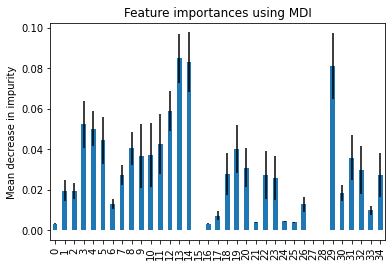

In [26]:
import pandas as pd
figure(figsize=(20, 8), dpi=200)
forest_importances = pd.Series(importances)#, index=feature_names)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()

In [24]:
fig.save_fig('image.jpg')

AttributeError: 'Figure' object has no attribute 'save_fig'